In [68]:
# General purpose
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob

# Metrics
from cellpose_omni.metrics import average_precision

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
#plt.style.use('dark_background')
from skimage import io

## Segmentation metrics calculation

In [2]:
def BorderRemoval(mask:np.array):

    def BorderElements(array:np.array, width:int): 
    
        n = array.shape[0]
        r = np.minimum(np.arange(n)[::-1], np.arange(n))
    
        a =  array[np.minimum(r[:,None],r)<width]

        return a[a.nonzero()]

    
    borderIDs = BorderElements(mask,2)

    if len(borderIDs) == 0:
        return mask

    else:
        
        CopyArray = np.copy(mask)

        for ID in borderIDs:

            Negative_mask = (mask != ID)
        
            CopyArray *= Negative_mask
    
        return CopyArray


In [69]:
manual_masks = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/Test_masks/*.tif'))

omnipose_masks_deconvolved = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/omnipose_deconvolved_masks/masks_GUI/0*'))
omnipose_masks_raw = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/omnipose_raw_masks/0*'))

omnipose_masks_bwo_d = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/BWO_masks_deconvolved/0*'))
cyto3_masks_d = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/Cyto3_masks_deconvolved/0*'))

omnipose_masks_bwo_r = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/BWO_masks_raw/0*'))
cyto3_masks_r = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/Cyto3_masks_raw/0*'))

print(len(manual_masks))

manual_masks = [io.imread(mask) for mask in manual_masks]

# Remove border segmentations
omnipose_masks_deconvolved = [BorderRemoval(io.imread(mask)) for mask in omnipose_masks_deconvolved]
omnipose_masks_raw = [BorderRemoval(io.imread(mask)) for mask in omnipose_masks_raw]

omnipose_masks_bwo_d = [BorderRemoval(io.imread(mask)) for mask in omnipose_masks_bwo_d]
cyto3_masks_d = [BorderRemoval(io.imread(mask)) for mask in cyto3_masks_d]

omnipose_masks_bwo_r = [BorderRemoval(io.imread(mask)) for mask in omnipose_masks_bwo_r]
cyto3_masks_r = [BorderRemoval(io.imread(mask)) for mask in cyto3_masks_r]



16


In [70]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

JI_deconvolved, tp, fp, fn = average_precision(manual_masks,omnipose_masks_deconvolved,threshold=thresholds)
f1_deconvolved = 2*tp/(2*tp+fn+fp)

JI_bwo_d, tp, fp, fn = average_precision(manual_masks,omnipose_masks_bwo_d,threshold=thresholds)
f1_bwo_d = 2*tp/(2*tp+fn+fp)

JI_cyto3_d, tp, fp, fn = average_precision(manual_masks,cyto3_masks_d,threshold=thresholds)
f1_cyto3_d = 2*tp/(2*tp+fn+fp)

In [71]:
dfs = []

for i in range(len(manual_masks)):

    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
    df3 = pd.DataFrame()

    df1.insert(0,'F1',f1_deconvolved[i])
    df1.insert(0,'Threshold',thresholds)
    df1.insert(0,'Model','Our model')

    df2.insert(0,'F1',f1_bwo_d[i])
    df2.insert(0,'Threshold',thresholds)
    df2.insert(0,'Model','bact_worm_omni')

    df3.insert(0,'F1',f1_cyto3_d[i])
    df3.insert(0,'Threshold',thresholds)
    df3.insert(0,'Model','Cyto3')

    df = pd.concat([df1,df2,df3],ignore_index=True)
    dfs.append(df)

dfs = pd.concat(dfs,ignore_index=True)

/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_3791/1034001580.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(labels=ax[0].get_yticklabels(),fontsize=12)
/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_3791/1034001580.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=ax[0].get_xticklabels(),fontsize=12)
/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_3791/1034001580.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(labels=ax[1].get_yticklabels(),fontsize=12)


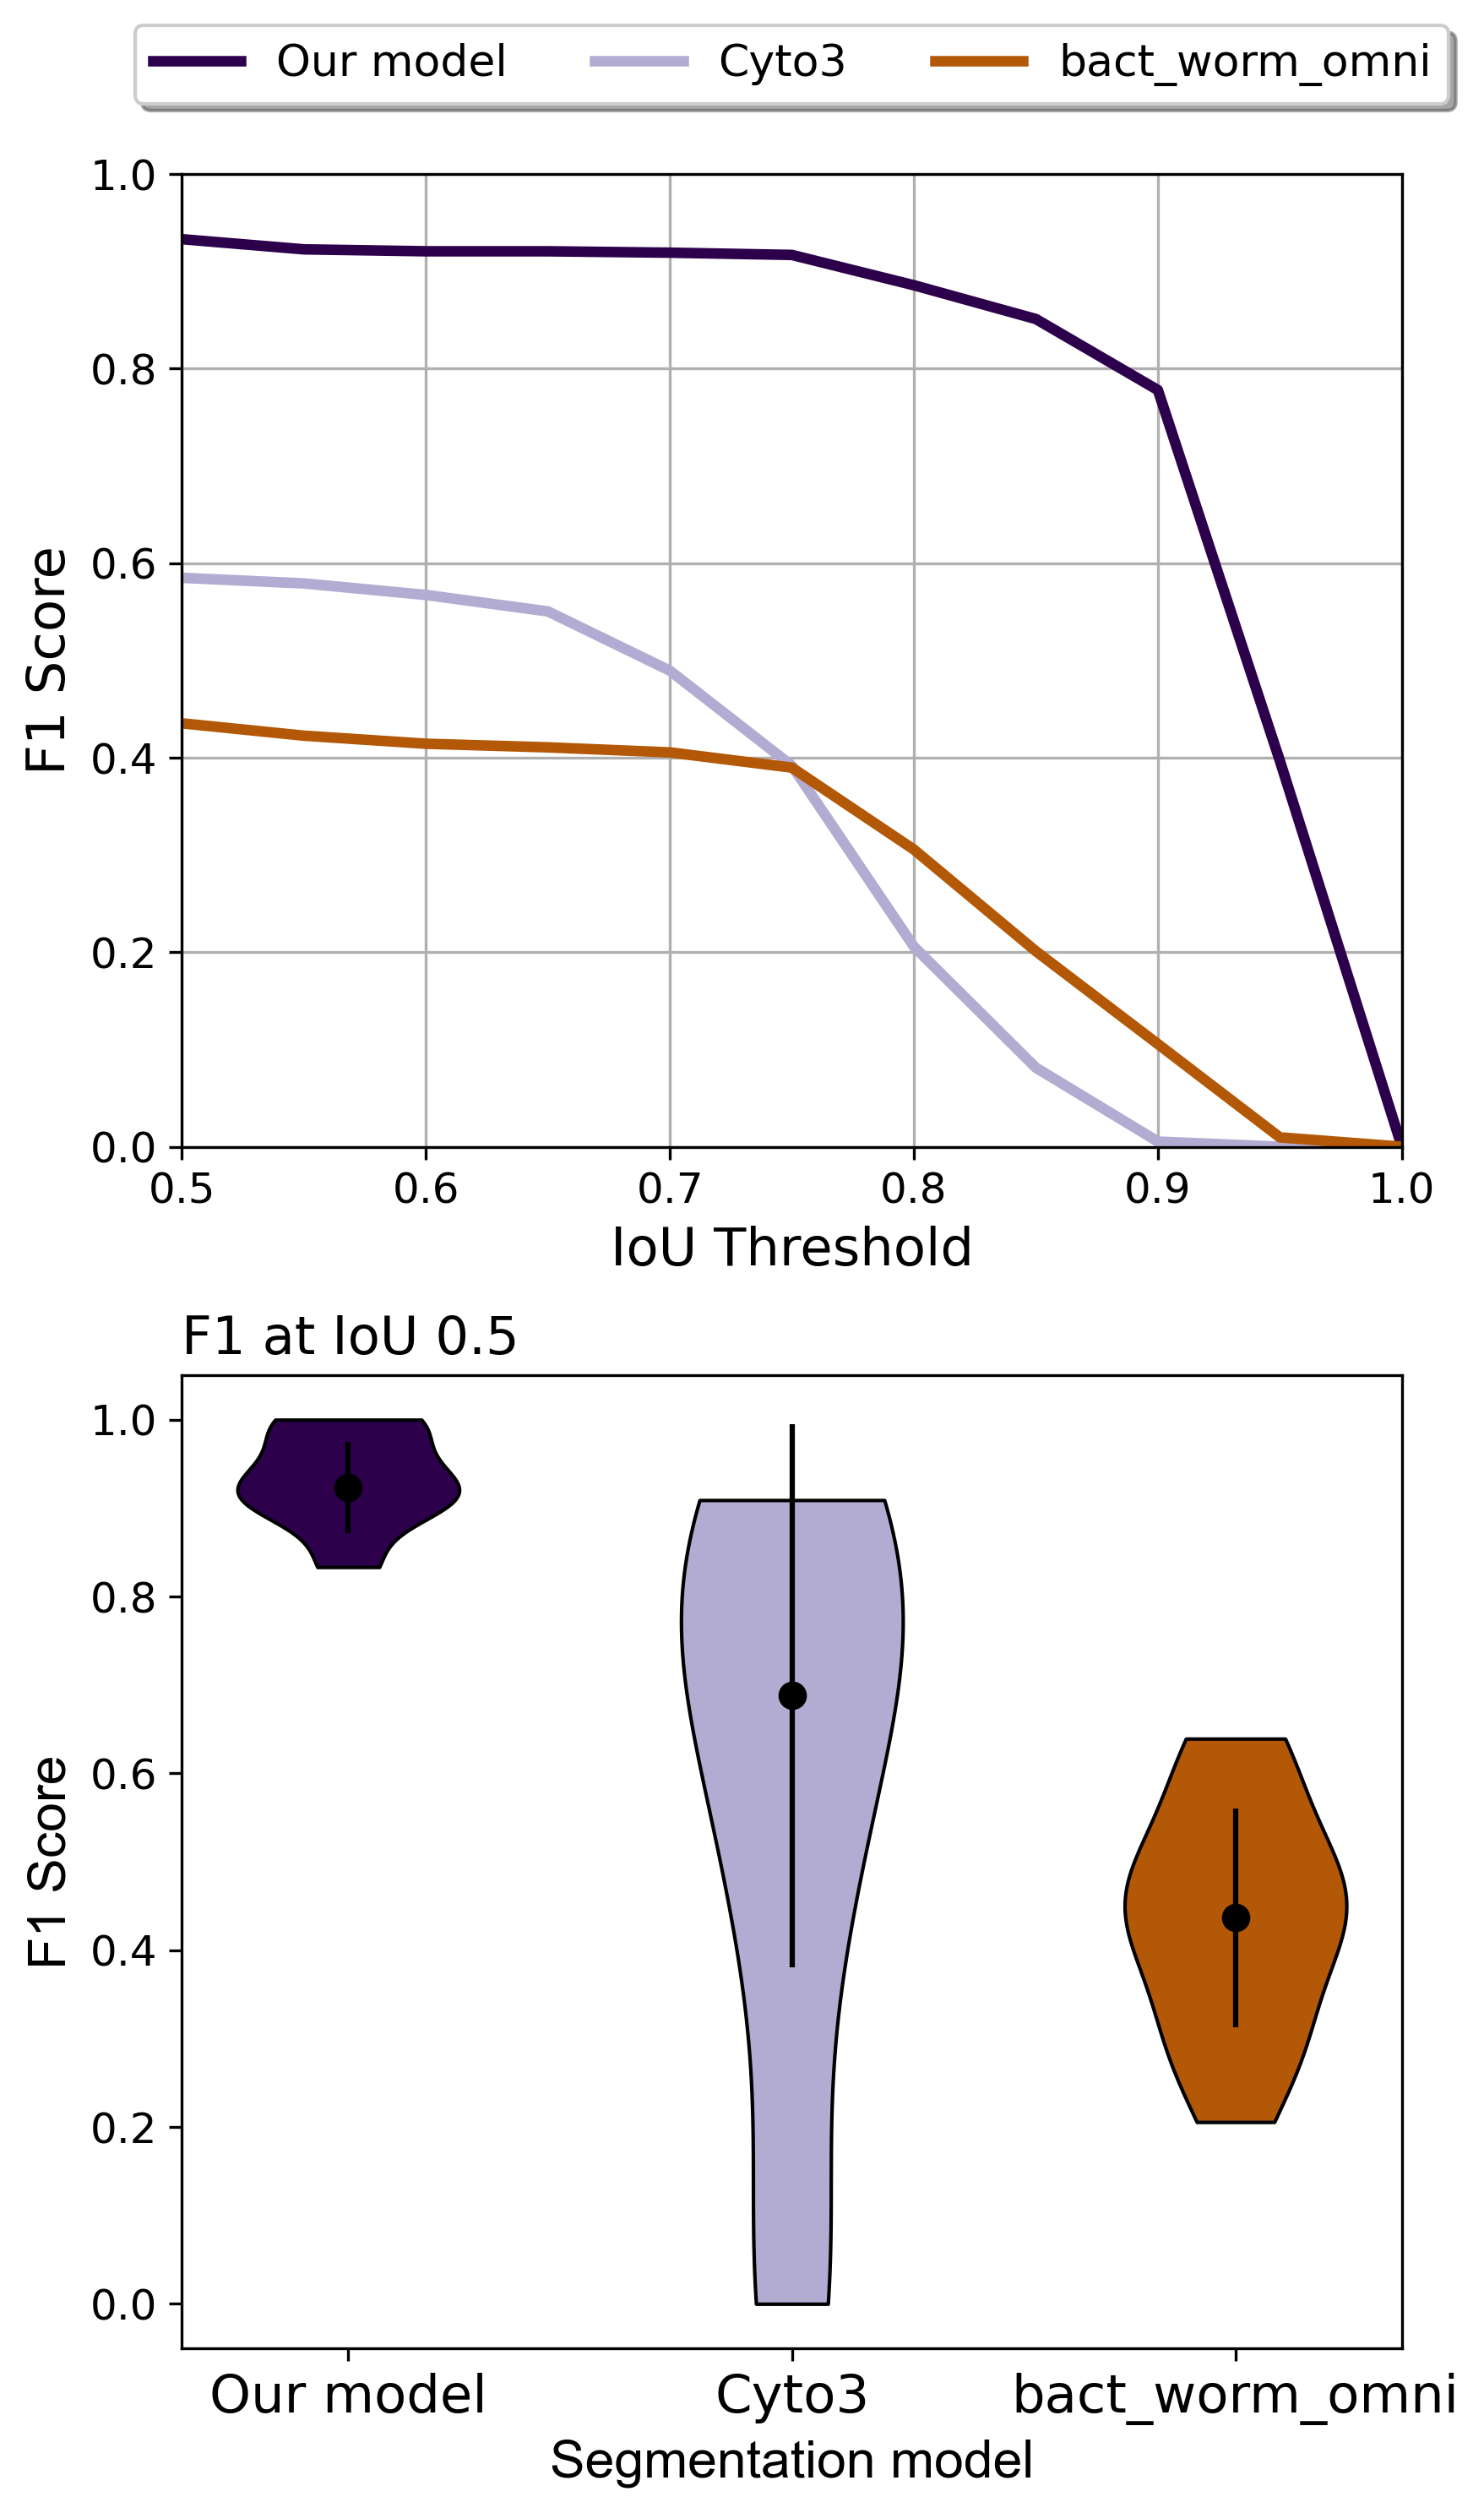

In [72]:
fig,ax = plt.subplots(dpi=300, nrows=2, ncols=1, figsize=(6,10))

ax[0].grid(visible=True,axis='both')
ax[0].set_ylabel('F1 Score',fontsize=15)
ax[0].set_ylim(0,1)
ax[0].set_yticklabels(labels=ax[0].get_yticklabels(),fontsize=12)

ax[0].set_xlabel('IoU Threshold',fontsize=15)
ax[0].set_xlim(0.5,1)
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(),fontsize=12)

models = ['Our model','Cyto3','bact_worm_omni']
colors = ['#2d004b','#b2abd2','#b35806']

for i,model in enumerate(models):
    
    subdf = dfs[dfs['Model'] == model]
    #ax.scatter(subdf['Threshold'],subdf['F1'],label=model)
    newdf = subdf.drop('Model',axis=1).groupby('Threshold').mean()
    ax[0].plot(newdf,label=model, c=colors[i], linewidth=3)
    
ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),fancybox=True, shadow=True, ncol=3,fontsize=12.5)
#ax[0].axhline(0.9)

positions = [0,1,2]
fscores = [f1_deconvolved[:,0],f1_cyto3_d[:,0],f1_bwo_d[:,0]]

parts1 = ax[1].violinplot(fscores,positions,showmeans=False,showmedians=False,showextrema=False)

for i,pc in enumerate(parts1['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)
for f,p in zip(fscores,positions):
    ax[1].errorbar(x=p,y=np.median(f),yerr=np.std(f),color='black')
    ax[1].scatter(x=p,y=np.median(f),color='black',s=50)
    
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['Our model','Cyto3','bact_worm_omni'],fontsize=15)
ax[1].set_xlabel('Segmentation model', fontsize=15,fontname='Arial')
ax[1].set_ylabel('F1 Score',fontname='Arial',fontsize=15)
ax[1].set_yticklabels(labels=ax[1].get_yticklabels(),fontsize=12)
#ax[1].set_xlim(-.5,1.5)
ax[1].set_title('F1 at IoU 0.5', fontsize=15, loc='left')

fig.tight_layout()
fig.savefig('/Users/reyesmatte/F1_scores_deconvolved.png')

In [73]:
JI_raw, tp, fp, fn = average_precision(manual_masks,omnipose_masks_raw,threshold=thresholds)
f1_raw = 2*tp/(2*tp+fn+fp)

JI_cyto3_r, tp, fp, fn = average_precision(manual_masks,cyto3_masks_r,threshold=thresholds)
f1_cyto3_r = 2*tp/(2*tp+fn+fp)

mm2 = manual_masks
mm2.pop(-2)

JI_bwo_r, tp, fp, fn = average_precision(mm2,omnipose_masks_bwo_r,threshold=thresholds)
f1_bwo_r = 2*tp/(2*tp+fn+fp)

In [74]:
dfs = []

for i in range(len(manual_masks)):

    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
    df3 = pd.DataFrame()

    df1.insert(0,'F1',f1_raw[i])
    df1.insert(0,'Threshold',thresholds)
    df1.insert(0,'Model','Our model')

    df2.insert(0,'F1',f1_bwo_r[i])
    df2.insert(0,'Threshold',thresholds)
    df2.insert(0,'Model','bact_worm_omni')

    df3.insert(0,'F1',f1_cyto3_r[i])
    df3.insert(0,'Threshold',thresholds)
    df3.insert(0,'Model','Cyto3')

    df = pd.concat([df1,df2,df3],ignore_index=True)
    dfs.append(df)

dfs = pd.concat(dfs,ignore_index=True)

/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_3791/4143637320.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(labels=ax[0].get_yticklabels(),fontsize=12)
/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_3791/4143637320.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels=ax[0].get_xticklabels(),fontsize=12)
/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_3791/4143637320.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(labels=ax[1].get_yticklabels(),fontsize=12)


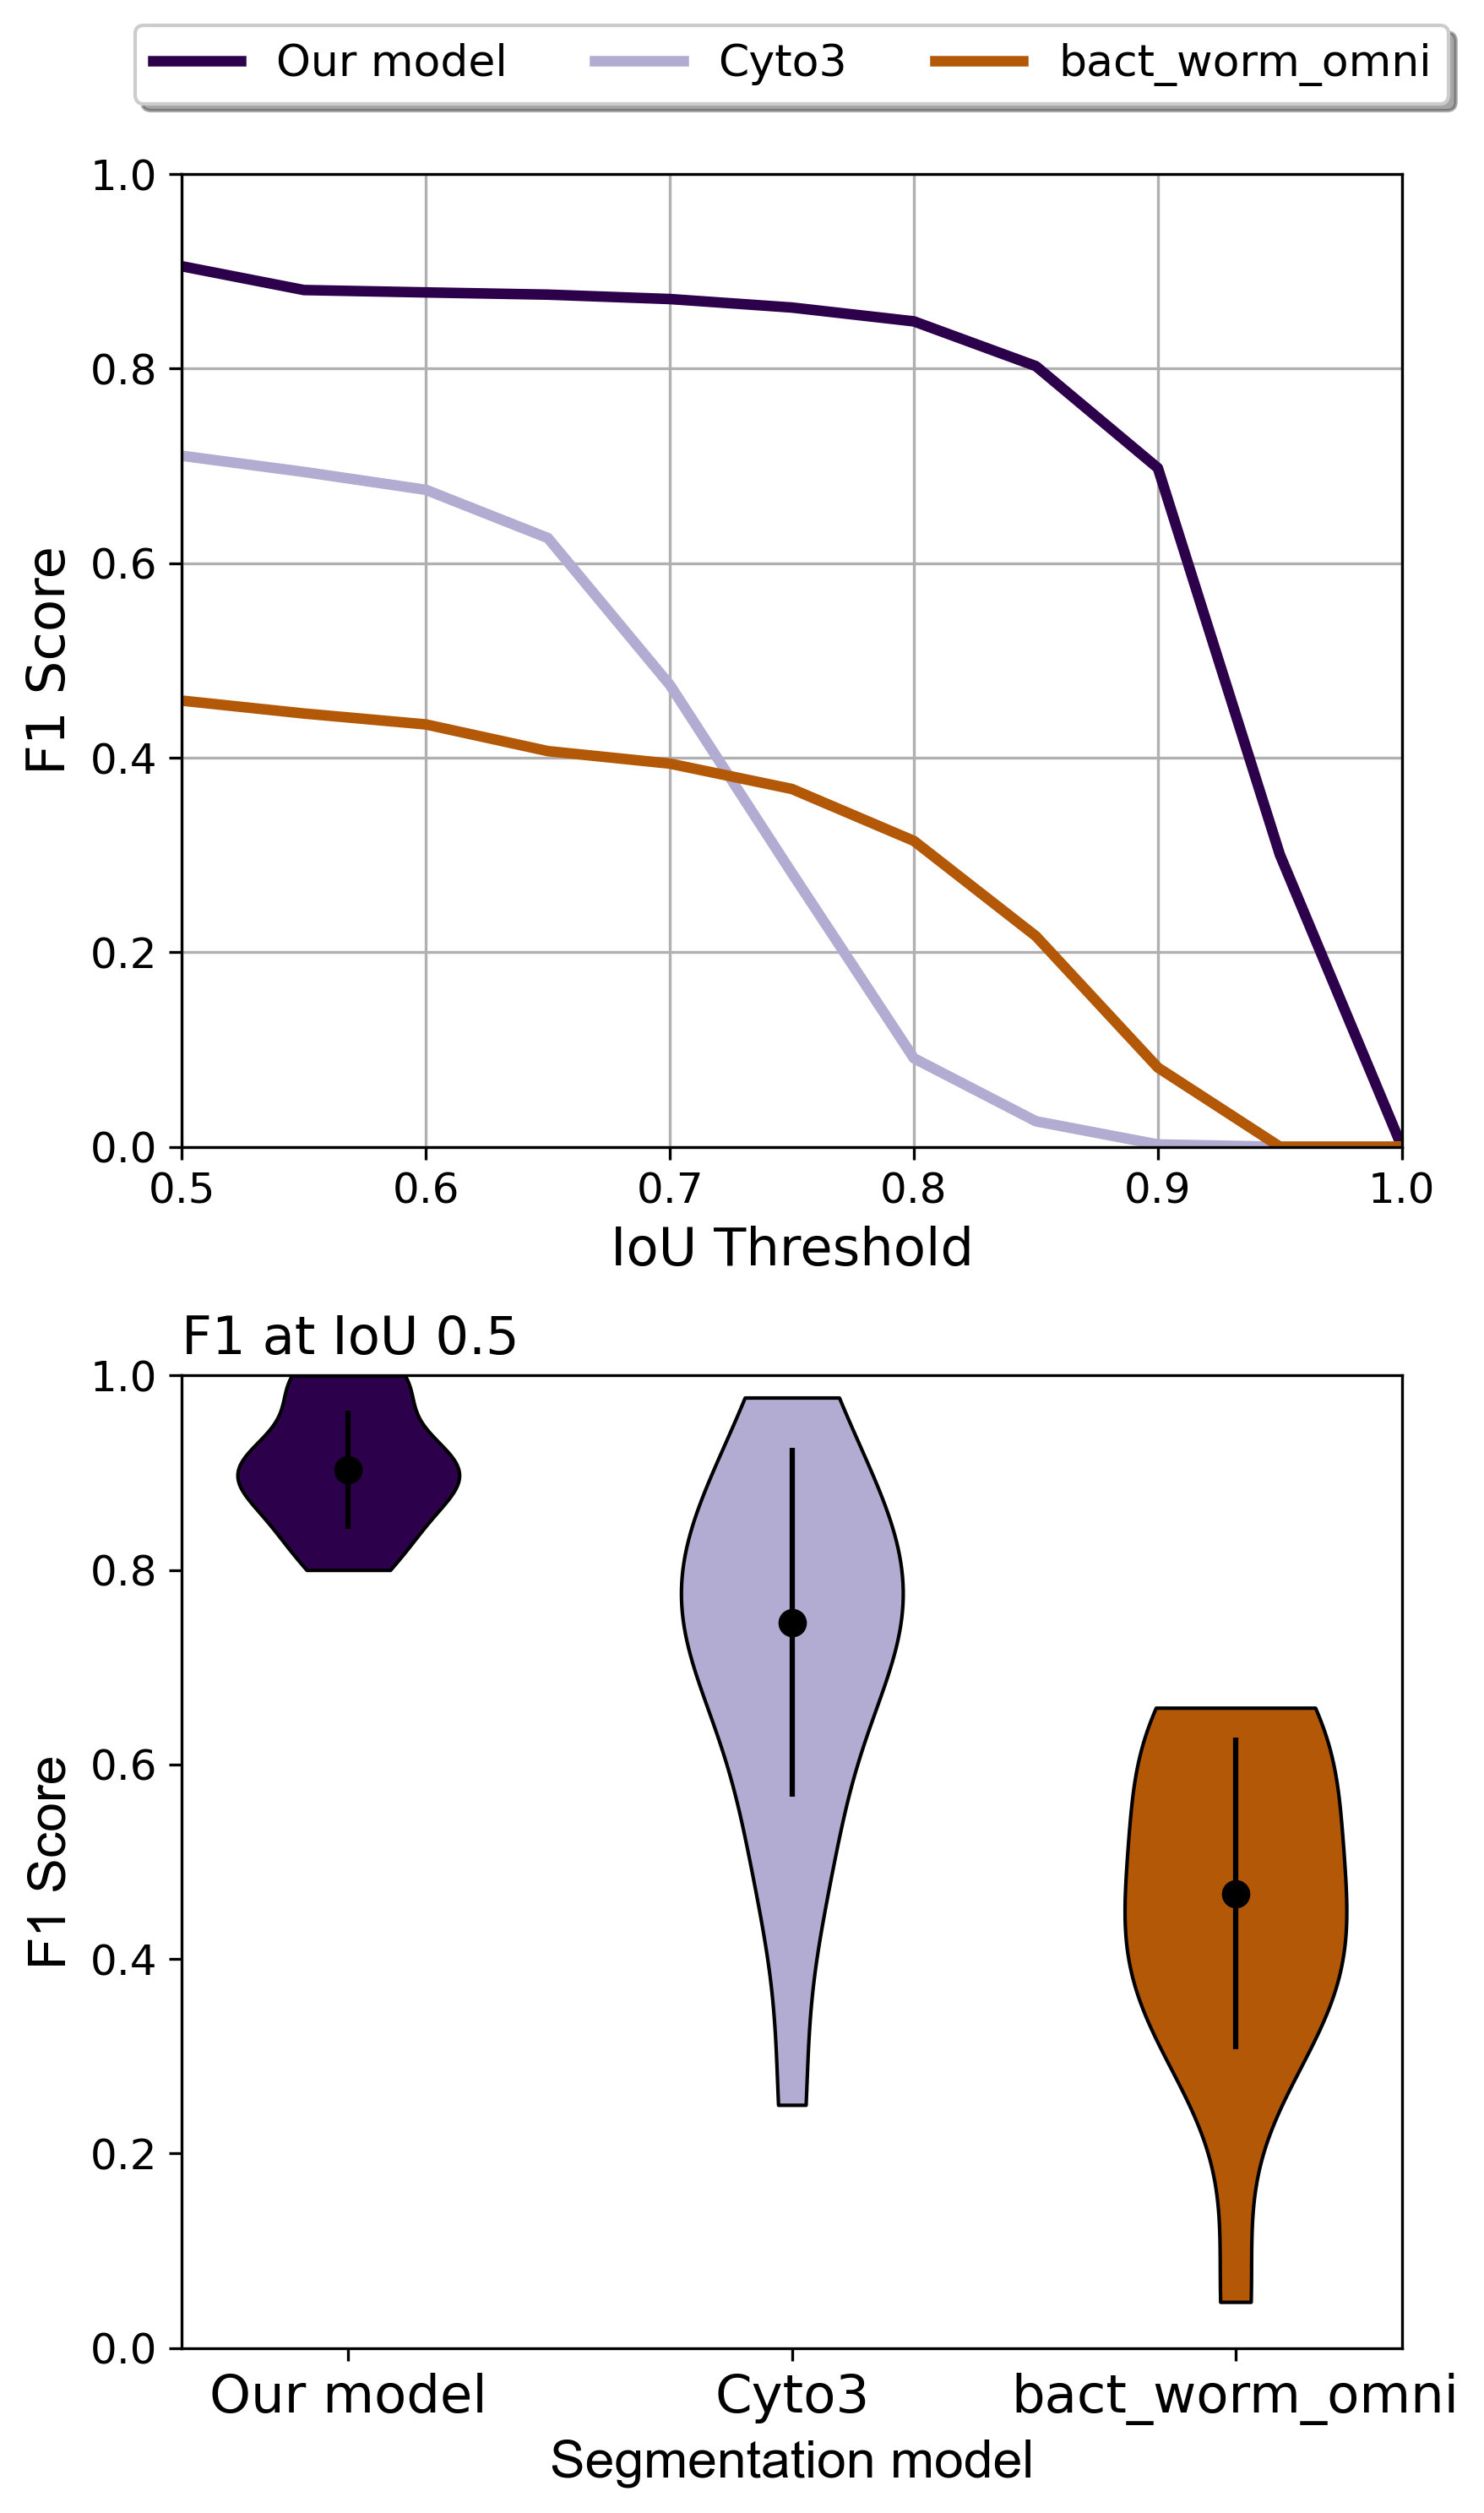

In [75]:
fig,ax = plt.subplots(dpi=300, nrows=2, ncols=1, figsize=(6,10))

ax[0].grid(visible=True,axis='both')
ax[0].set_ylabel('F1 Score',fontsize=15)
ax[0].set_ylim(0,1)
ax[0].set_yticklabels(labels=ax[0].get_yticklabels(),fontsize=12)

ax[0].set_xlabel('IoU Threshold',fontsize=15)
ax[0].set_xlim(0.5,1)
ax[0].set_xticklabels(labels=ax[0].get_xticklabels(),fontsize=12)

models = ['Our model','Cyto3','bact_worm_omni']
colors = ['#2d004b','#b2abd2','#b35806']

for i,model in enumerate(models):
    
    subdf = dfs[dfs['Model'] == model]
    #ax.scatter(subdf['Threshold'],subdf['F1'],label=model)
    newdf = subdf.drop('Model',axis=1).groupby('Threshold').mean()
    ax[0].plot(newdf,label=model, c=colors[i], linewidth=3)
    
ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),fancybox=True, shadow=True, ncol=3,fontsize=12.5)

positions = [0,1,2]
fscores = [f1_raw[:,0],f1_cyto3_r[:,0],f1_bwo_r[:,0]]

parts1 = ax[1].violinplot(fscores,positions,showmeans=False,showmedians=False,showextrema=False)

for i,pc in enumerate(parts1['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)
for f,p in zip(fscores,positions):
    ax[1].errorbar(x=p,y=np.median(f),yerr=np.std(f),color='black')
    ax[1].scatter(x=p,y=np.median(f),color='black',s=50)
    
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['Our model','Cyto3','bact_worm_omni'],fontsize=15)
ax[1].set_xlabel('Segmentation model', fontsize=15,fontname='Arial')
ax[1].set_ylim(0,1)
ax[1].set_ylabel('F1 Score',fontname='Arial',fontsize=15)
ax[1].set_yticklabels(labels=ax[1].get_yticklabels(),fontsize=12)
ax[1].set_title('F1 at IoU 0.5', fontsize=15, loc='left')

fig.tight_layout()
fig.savefig('/Users/reyesmatte/F1_scores_rawFM.png')

In [4]:
from scipy.special import kl_div

def KL_calculator(p,q, bins=10):

    pq = np.concatenate([p,q])

    ## Add 10^-10 to prevent having values equal to 0
    p_pdf = np.histogram(p,range=(pq.min(),pq.max()),density=True,bins=bins)[0] + 10**(-10)
    q_pdf = np.histogram(q,range=(pq.min(),pq.max()),density=True,bins=bins)[0] + 10**(-10)

    KL = np.round(sum(kl_div(p_pdf,q_pdf)),2)

    return KL

In [62]:
manual_masks = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/Test_masks/*.tif'))

GUI = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/omnipose_deconvolved_masks/masks_GUI/0*'))
CLI = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/omnipose_deconvolved_masks/masks_CLI/0*'))
Note = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/omnipose_deconvolved_masks/masks_notebook/0*'))
CLI_d = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/omnipose_deconvolved_masks/masks_CLI_deepbio/0*'))
Note_d = sorted(glob('/Volumes/evocell/Octavio/Omnipose/FMDeconvolved/GT_test/omnipose_deconvolved_masks/masks_notebook_deepbio/0*'))

manual_masks = [io.imread(mask) for mask in manual_masks]

# Remove border segmentations
GUI = [BorderRemoval(io.imread(mask)) for mask in GUI]
CLI = [BorderRemoval(io.imread(mask)) for mask in CLI]
Note = [BorderRemoval(io.imread(mask)) for mask in Note]
CLI_d = [BorderRemoval(io.imread(mask)) for mask in CLI_d]
Note_d = [BorderRemoval(io.imread(mask)) for mask in Note_d]

In [63]:
thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

masks = [GUI,CLI,CLI_d,Note,Note_d]
method = ['GUI','CLI','CLI\ndeepbio','Notebook','Notebook\ndeepbio']

dfs = []

for i,mask in enumerate(masks):

    JI, tp, fp, fn = average_precision(manual_masks,mask,threshold=thresholds)
    f1 = 2*tp/(2*tp+fn+fp)

    df = []
    
    for j, iou in enumerate(thresholds):

        df_ = pd.DataFrame()

        df_.insert(0,'F1',f1[:,j])
        df_.insert(0,'Threshold',iou)
        df_.insert(0,'Method',method[i])

        df.append(df_)

    df = pd.concat(df,ignore_index=True)

    dfs.append(df)

dfs = pd.concat(dfs,ignore_index=True)

2025-01-09 13:20:35,385 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-09 13:20:35,391 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_3791/1596156159.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=ax.get_yticklabels(),fontsize=12)
/var/folders/q6/szs86xgn755_g81_n0cyblxc0000gp/T/ipykernel_3791/1596156159.py:7: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x=dfs['Threshold'],y=dfs['F1'],hue=dfs['Method'],palette=sns.color_palette('colorblind'))
/Users/reyesmatte/mambaforge/envs/omnipose/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/reyesmatte/mambaforge/envs/omnipose/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: Wh

[Text(0, 0, '0.5'),
 Text(1, 0, '0.55'),
 Text(2, 0, '0.6'),
 Text(3, 0, '0.65'),
 Text(4, 0, '0.7'),
 Text(5, 0, '0.75'),
 Text(6, 0, '0.8'),
 Text(7, 0, '0.85'),
 Text(8, 0, '0.9')]

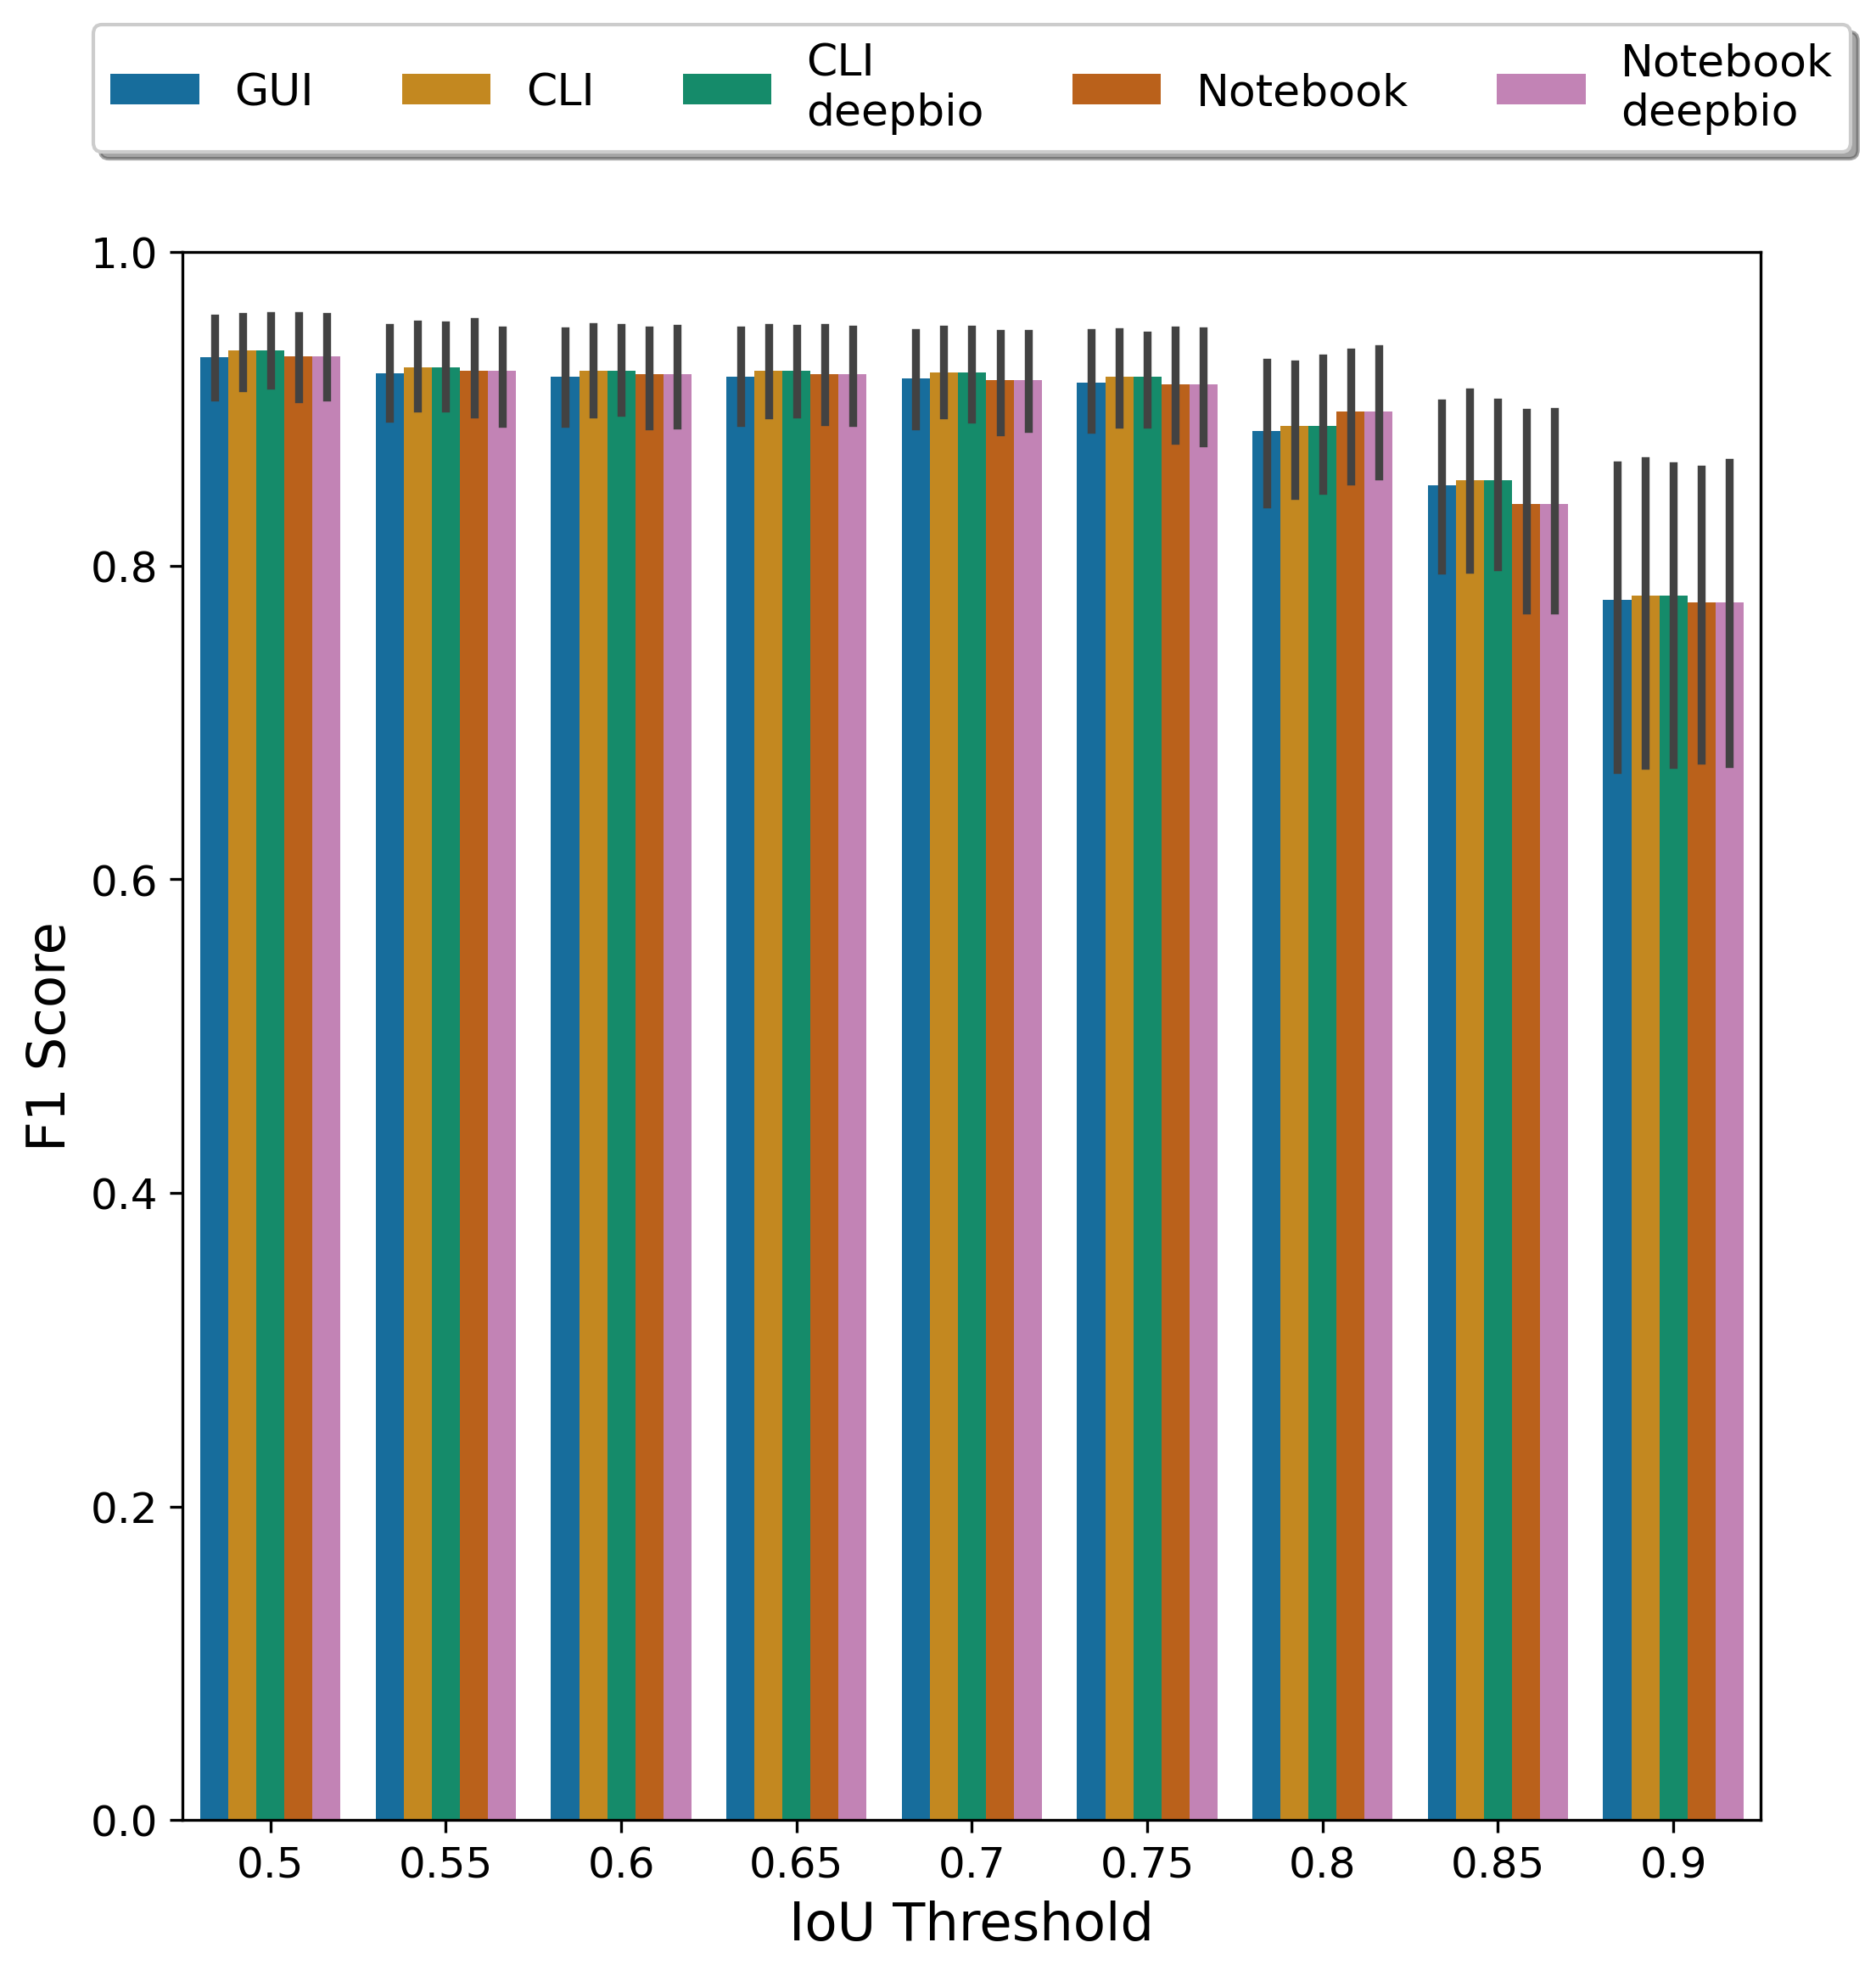

In [67]:
fig,ax = plt.subplots(dpi=300, nrows=1, ncols=1, figsize=(8,8))

ax.set_ylabel('F1 Score',fontsize=15)
ax.set_ylim(0,1)
ax.set_yticklabels(labels=ax.get_yticklabels(),fontsize=12)

sns.barplot(x=dfs['Threshold'],y=dfs['F1'],hue=dfs['Method'],palette=sns.color_palette('colorblind'))

ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),fancybox=True, shadow=True, ncol=5,fontsize=12.5)

ax.set_xlabel('IoU Threshold',fontsize=15)
ax.set_xticklabels(labels=ax.get_xticklabels(),fontsize=12)


/Users/reyesmatte/mambaforge/envs/omnipose/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/reyesmatte/mambaforge/envs/omnipose/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/reyesmatte/mambaforge/envs/omnipose/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_

<Axes: xlabel='Method', ylabel='F1'>

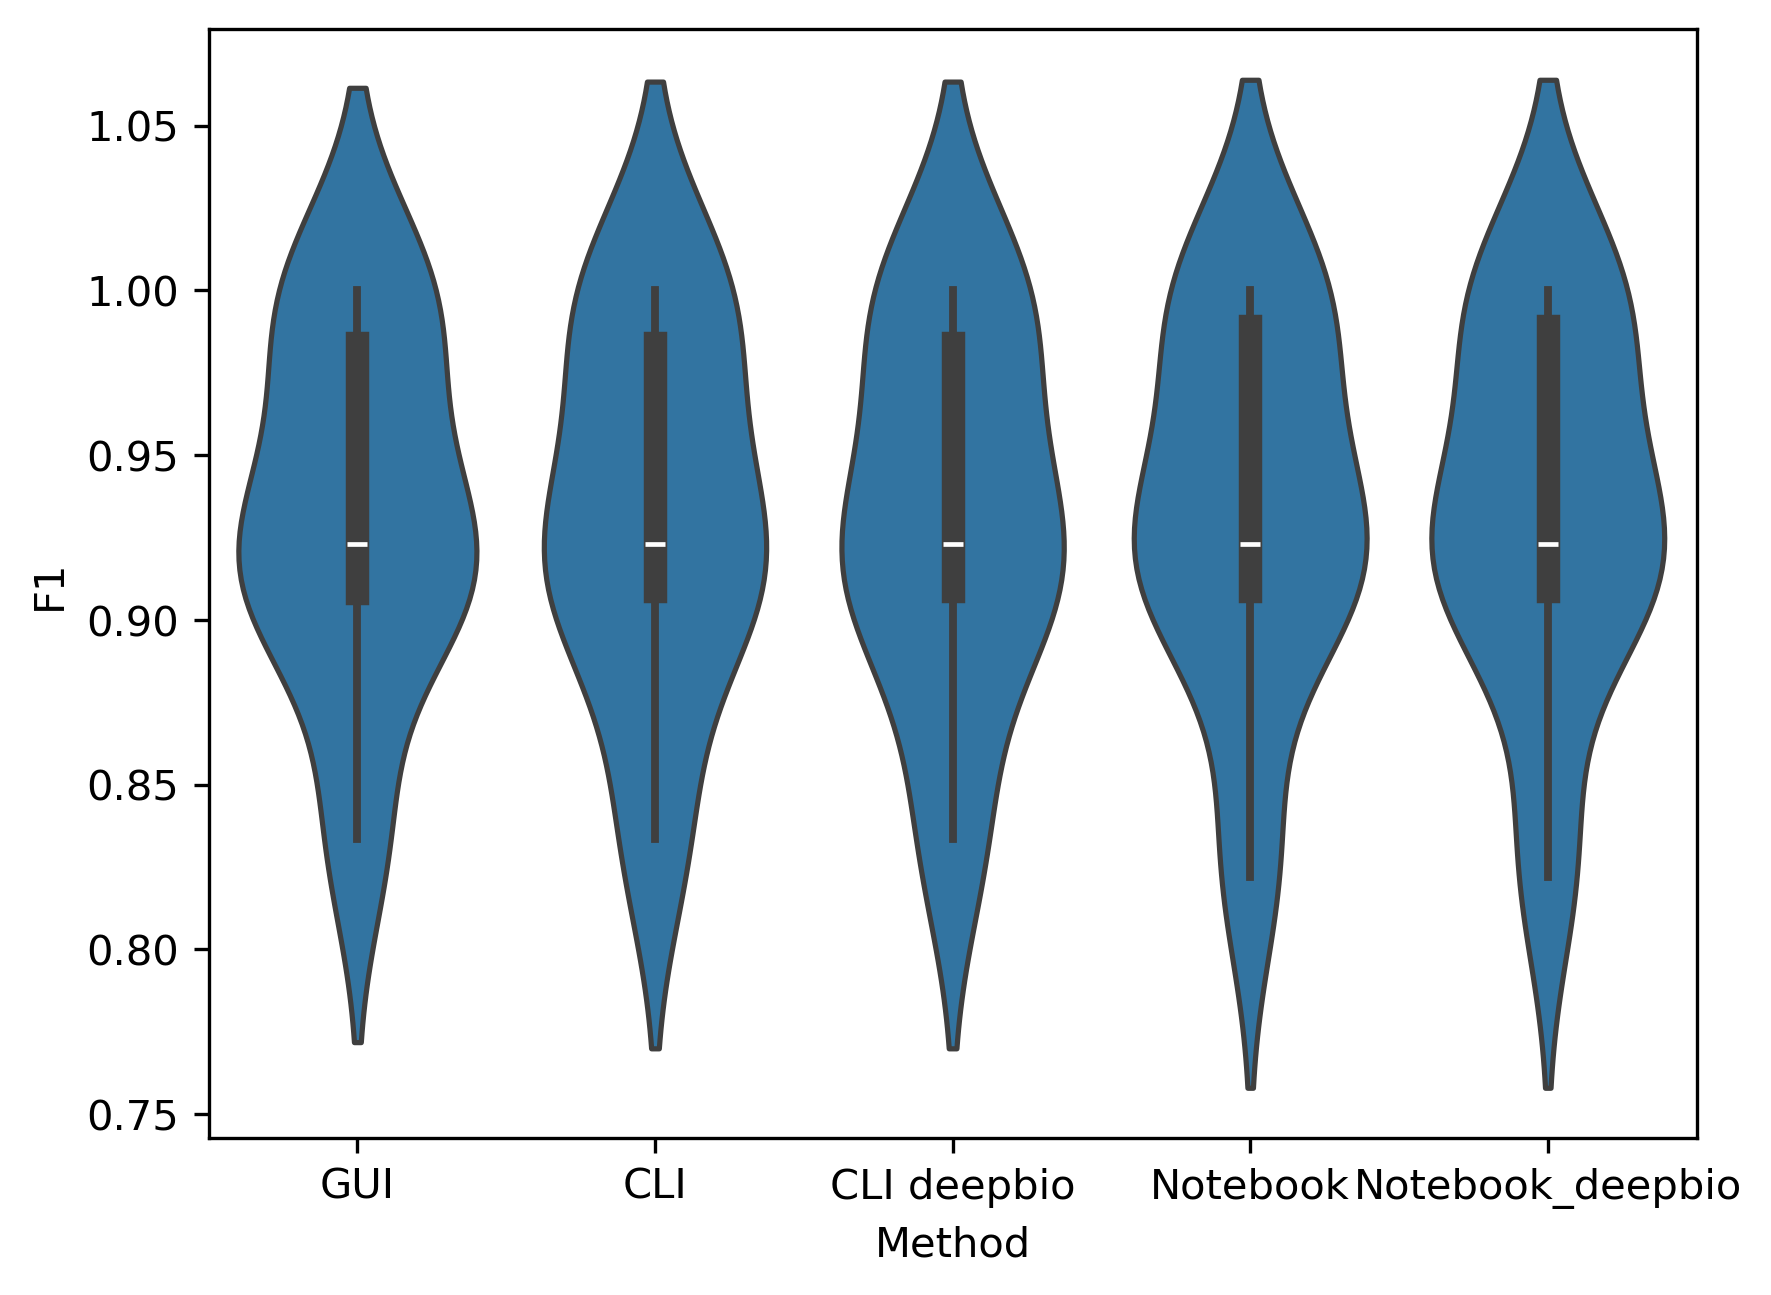

In [25]:
iou05 = dfs[dfs['Threshold'] == 0.5]

sns.violinplot(x=iou05['Method'],y=iou05['F1'])

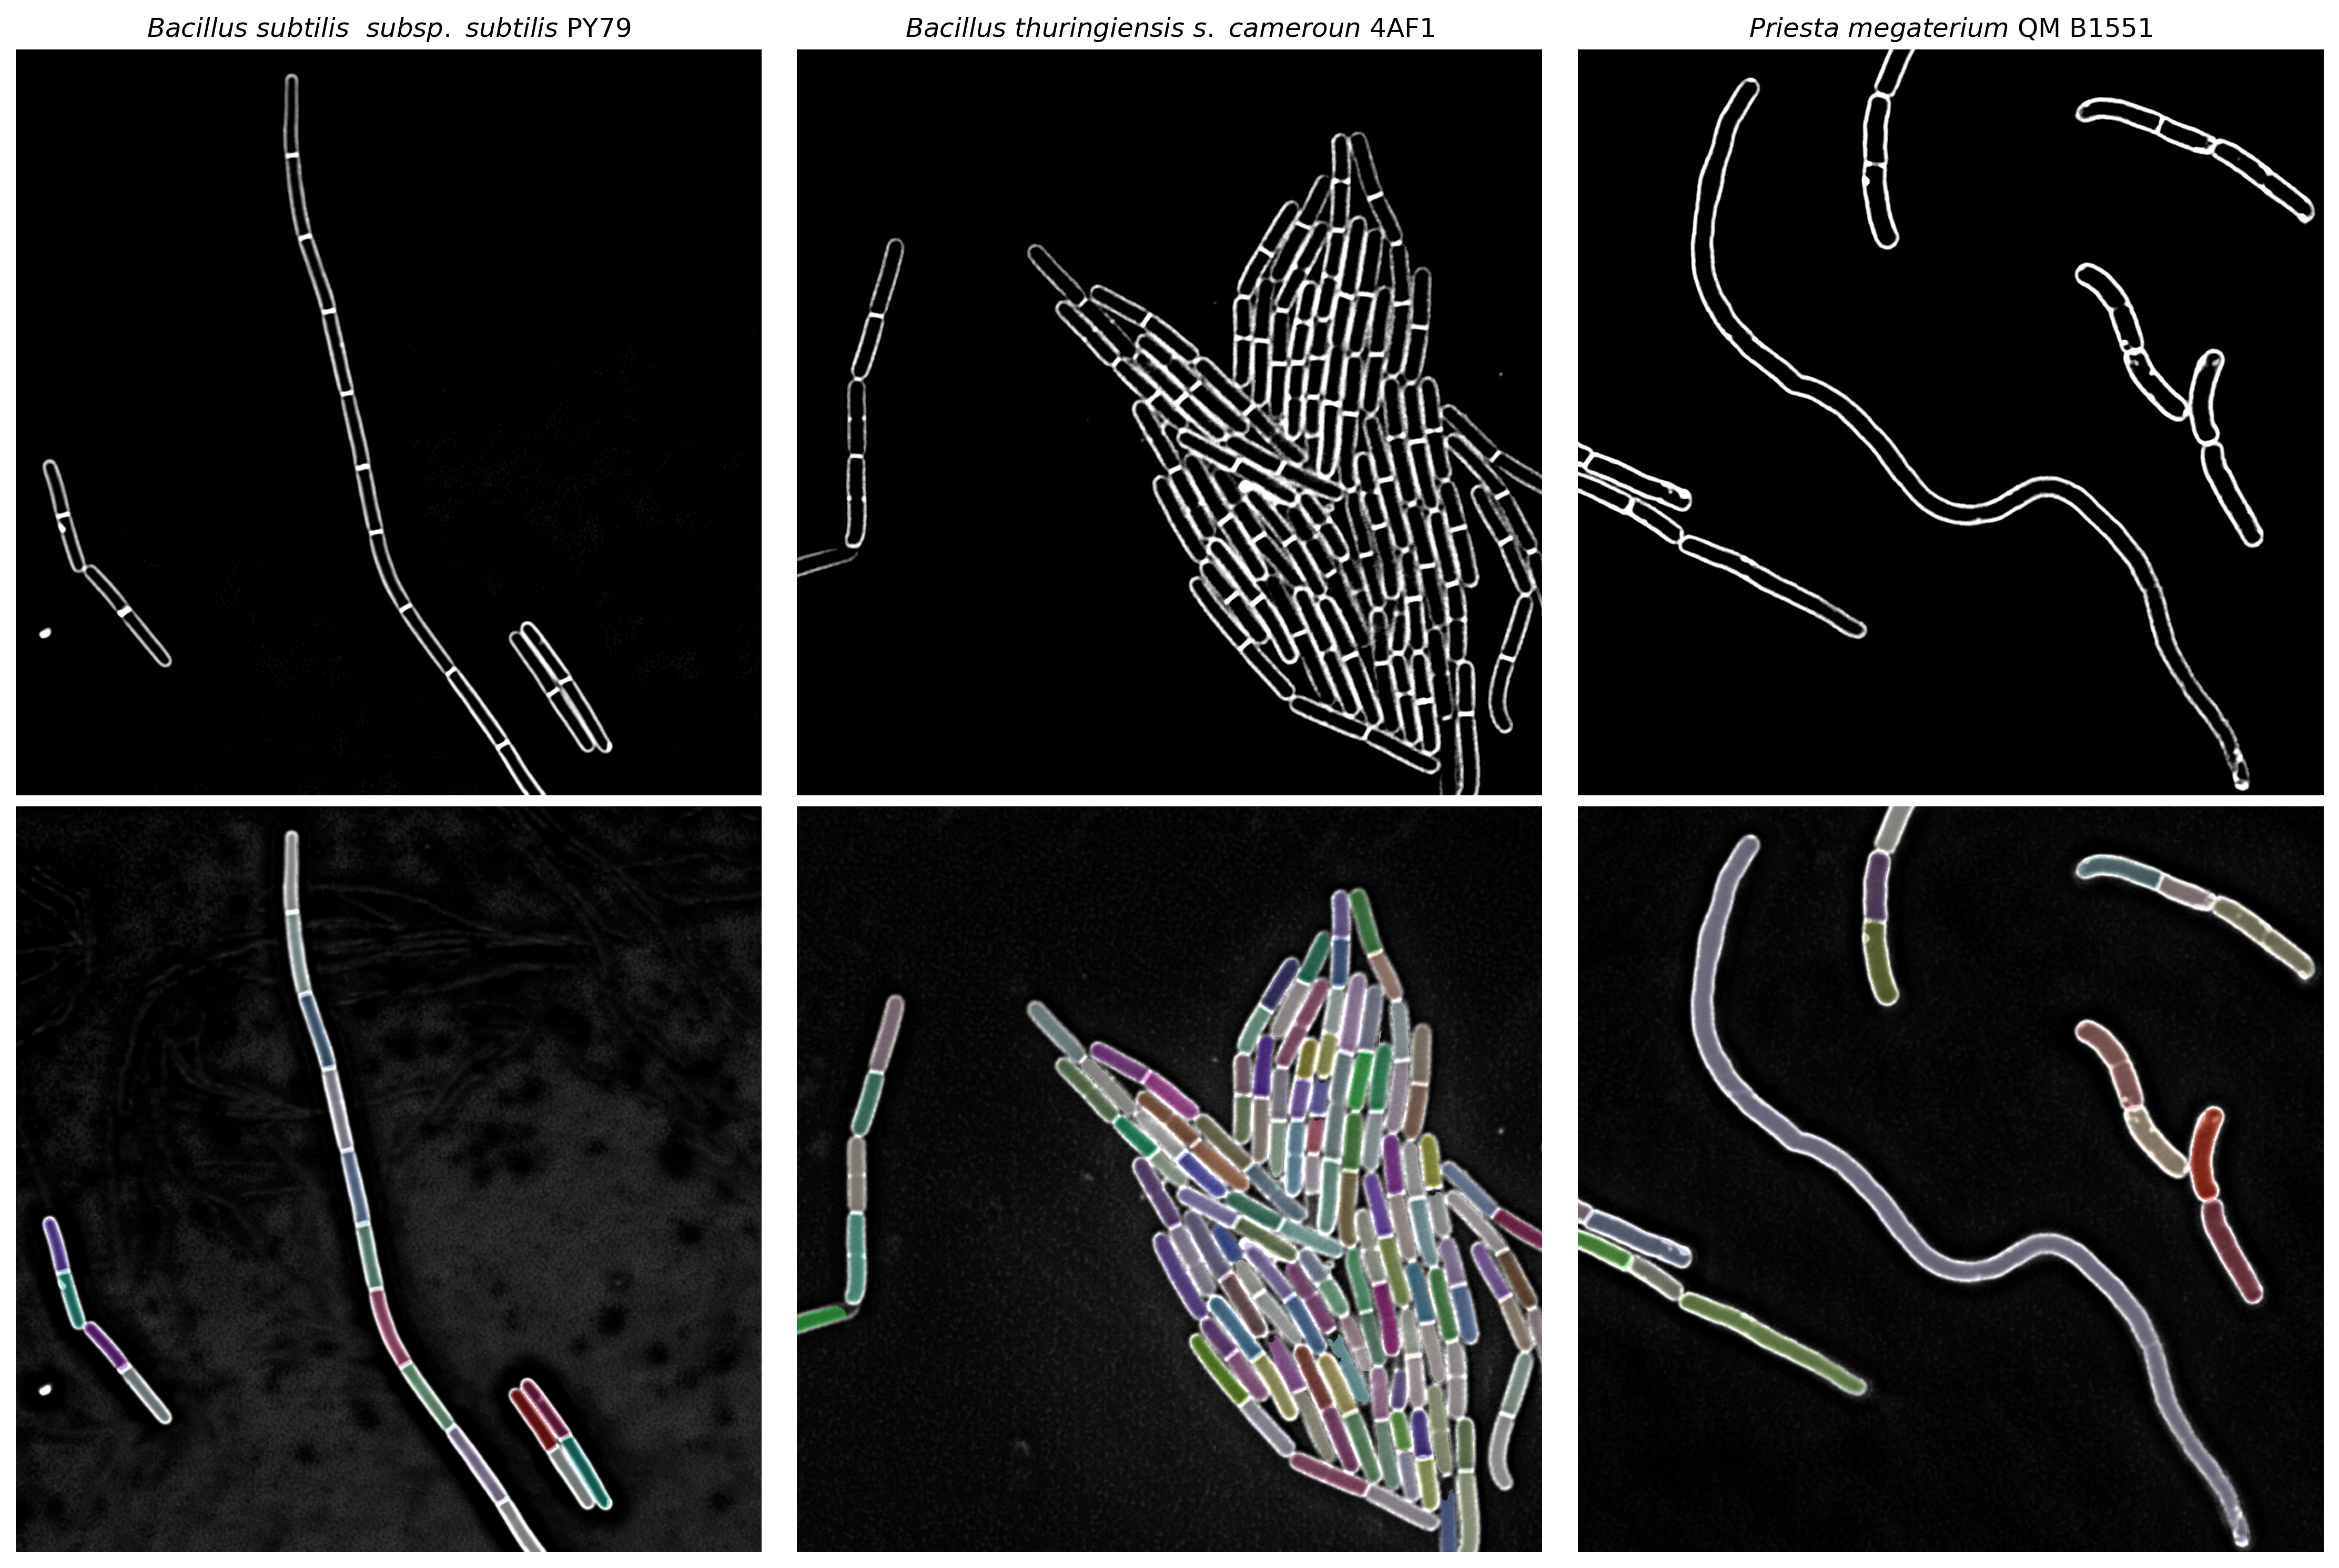

In [11]:
plt.figure(dpi=300,figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(a1[0],cmap='Greys_r',vmax=30000,vmin=5000)
plt.axis('off')
plt.xlim(300,1100)
plt.ylim(800,0)
plt.title('$Bacillus$ $subtilis$  $subsp.$ $subtilis$ PY79')

plt.subplot(2,3,4)
plt.imshow(render_label(a2[0],img=a1[0]))
plt.axis('off')
plt.xlim(300,1100)
plt.ylim(800,0)

plt.subplot(2,3,2)
plt.imshow(a1[1],cmap='Greys_r',vmax=3000,vmin=1000)
plt.xlim(left=1248)
plt.ylim(900,100)
plt.axis('off')
plt.title('$Bacillus$ $thuringiensis$ $s.$ $cameroun$ 4AF1')

plt.subplot(2,3,5)
plt.imshow(render_label(a2[1],img=a1[1]))
plt.xlim(left=1248)
plt.ylim(900,100)
plt.axis('off')


plt.subplot(2,3,3)
plt.imshow(a1[2],cmap='Greys_r',vmax=3000,vmin=1000)
plt.xlim(200,1000)
plt.ylim(1500,700)
plt.axis('off')
plt.title('$Priesta$ $megaterium$ QM B1551')

plt.subplot(2,3,6)
plt.imshow(render_label(a2[2],img=a1[2]))
plt.xlim(200,1000)
plt.ylim(1500,700)
plt.axis('off')

plt.tight_layout()
plt.savefig('Segmentation_examples.png')

## Phase-FM-DAPI example

In [2]:
PY79 = sorted(glob('/Volumes/evocell/Octavio/I2K_poster/Segmentation/Examples/*PY79*subset*'))
Lysi = sorted(glob('/Volumes/evocell/Octavio/I2K_poster/Segmentation/Examples/*13A2*subset*'))

PY79 = [normalize(imread(img)) for img in PY79]
Lysi = [normalize(imread(img)) for img in Lysi]

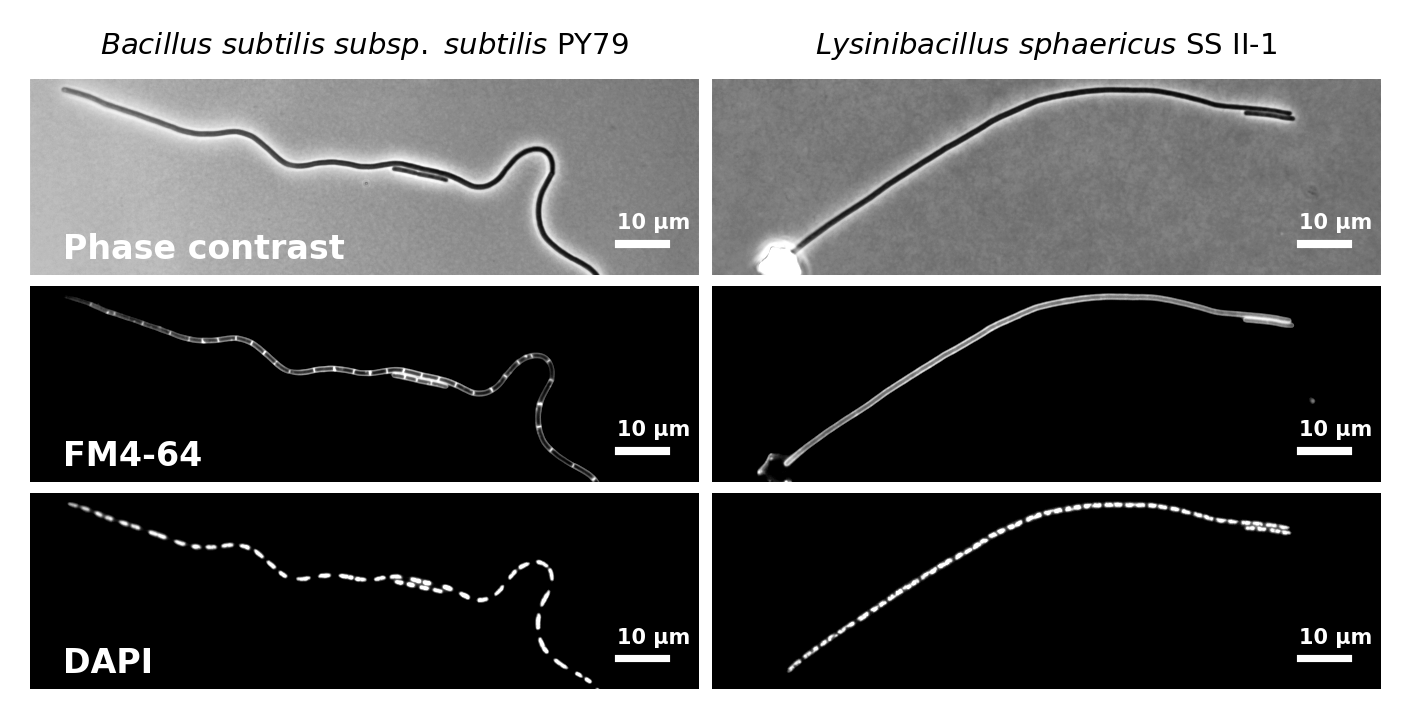

In [3]:
# Create figure and axes
fig = plt.figure(dpi=300,figsize=(15,10))

idxs = [-1,2,0]
j = 1
k = 0

labels = ['Phase contrast', 'FM4-64', 'DAPI']

for i in idxs:

    if j == 1:
        vmax = 1.2
        vmin = None
        
    elif j == 3:
        vmax = 1.2
        vmin = 0.4

    else:
        vmax = 0.8
        vmin = 0.2


    rect = patches.Rectangle((1800, 500), 156, 10, linewidth=1, edgecolor='w', facecolor='w')
    
    # Display the image
    ax = fig.add_subplot(3,2,j)
    ax.imshow(PY79[i],cmap='Greys_r',vmax=vmax,vmin=vmin)
    ax.axis('off')
    ax.add_patch(rect)
    ax.text(1800,460,'10 µm',color='white',fontsize=5,fontweight='bold')
    ax.text(100,550,labels[k],color='white',fontsize=8,fontweight='bold')
    if j == 1:
        ax.set_title('$Bacillus$ $subtilis$ $subsp.$ $subtilis$ PY79',fontsize=7)

    
    if j == 1:
        vmax = 0.3
        vmin = None


    rect = patches.Rectangle((1800, 500), 156, 10, linewidth=1, edgecolor='w', facecolor='w')
    
    ax = fig.add_subplot(3,2,j+1)
    ax.imshow(Lysi[i],cmap='Greys_r',vmax=vmax,vmin=vmin)
    ax.axis('off')
    ax.add_patch(rect)
    ax.text(1800,460,'10 µm',color='white',fontsize=5,fontweight='bold')

    if j == 1:
        ax.set_title('$Lysinibacillus$ $sphaericus$ SS II-1',fontsize=7)
    
    j+=2
    k+=1

fig.tight_layout()
plt.subplots_adjust(left=0, right=0.3, bottom=0, top=0.22)
plt.savefig('PFD_examples.png')